<a href="https://colab.research.google.com/github/mamoru-gunji/Gradient-Based-Trajectory-Optimization/blob/main/Gradient_Based_Trajectory_Optimization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import torch
# from optimal.models.gitai import GITAI
# from gym_pybullet_drones.envs.single_agent_rl.HoverAviary import HoverAviary
# from gym_pybullet_drones.envs.single_agent_rl.BaseSingleAgentAviary import ActionType
import matplotlib.pyplot as plt

ストリーミング出力は最後の 5000 行に切り捨てられました。
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]
zero:  [[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]
zero:  [[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.

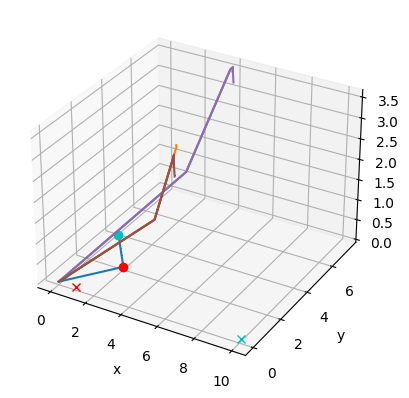

In [25]:
class Optimizer:

    def __init__(self, initial_x, u_seq, x_target, model=None, model_based=False, device=torch.device('cpu')):
        self.x_seq = np.zeros((len(u_seq)+1, initial_x.shape[0]))
        self.x_seq[0] = initial_x
        self.u_seq = np.array(u_seq)
        self.model = model
        self.device = device
        self.x_target = x_target
        self.model_based = model_based
        self.seq_len = u_seq.shape[0]
        self.compute_x_seq(self.u_seq)

    # (roll pitch yaw)がそれぞれ(x, y, z)の微分値であるようなモデルを考える
    def model_based_model(self, x, u):
        delta = [u[1], u[2], u[3], 0, 0, 0, 0, 0, 0, 0, 0, 0]
        return np.array(delta)

    def model_based_grad_f(self, x, u):
        du = np.zeros((x.shape[0], u.shape[0]))
        dx = np.zeros((x.shape[0], x.shape[0]))

        du[0,1] = 1
        du[1,2] = 1
        du[2,3] = 1

        return dx, du


    def compute_x_seq(self, u_seq):
        for i in range(self.seq_len):
            if self.model_based:
                self.x_seq[i+1] = self.x_seq[i] + self.model_based_model(self.x_seq[i], u_seq[i])
            else:
                x = torch.from_numpy(self.x_seq[i]).float().to(self.device)
                u = torch.from_numpy(u_seq[i]).float().to(self.device)
                input = torch.cat((x, u), 0)
                self.x_seq[i+1] = self.model(input).detach().cpu().numpy()

    def grad_f(self, x, u):
        if self.model_based:
            return self.model_based_grad_f(x, u)
        x = torch.from_numpy(x).float().to(self.device)
        u = torch.from_numpy(u).float().to(self.device)
        x.requires_grad_(True)
        u.requires_grad_(True)
        input = torch.cat((x, u), 0)
        delta = self.model(input)
        delta.backward()
        return x.grad, u.grad

    def grad_xu(self, i, j):
        grad = np.zeros((self.x_seq.shape[1], self.u_seq.shape[1]))
        if j < i -1:
            grad = np.dot(self.grad_xx(i, i-1),self.grad_xu(i-1, j))
        elif j == i - 1:
            grad = self.grad_f(self.x_seq[i-1], self.u_seq[i-1])[1]
        return grad

    def grad_xx(self, i, j):
        grad = np.zeros((self.x_seq.shape[1], self.x_seq.shape[1]))
        if j < i - 1:
            grad = np.dot(self.grad_xx(i, i-1),self.grad_xx(i-1, j))
        elif j == i - 1:
            grad = 1 + self.grad_f(self.x_seq[i-1], self.u_seq[i-1])[0]
        elif j == i:
            grad = np.ones((self.x_seq.shape[1], self.x_seq.shape[1]))
        return grad

    def partial_lx(self, i):
        # 目的関数に依存
        omega_target = 1
        grad = np.zeros(self.x_seq.shape[1])
        if type(self.x_target[i-1]) == list or type(self.x_target[i-1]) == np.ndarray:
            grad = omega_target * 2 * (self.x_seq[i] - np.array(self.x_target[i-1]))
        return grad

    def partial_lu(self, i):
        # 目的関数に依存
        # grad = np.zeros(self.u_seq.shape[1])
        omega_u = 0.2
        omega_jerk = 10
        grad = omega_u * 2 * self.u_seq[i]
        if i == 0:
            # print("i-1:", self.u_seq[i-1])
            # print("i:", self.u_seq[i])
            grad += omega_jerk * 2 * (self.u_seq[i] - self.u_seq[i+1])
        elif i == self.u_seq.shape[0] - 1:
            grad += omega_jerk * 2 * (self.u_seq[i] - self.u_seq[i-1])
        else:
            grad += omega_jerk * 2 * (- self.u_seq[i+1] + 2*self.u_seq[i] - self.u_seq[i-1])
        return grad

    def compute_grad(self):
        grad_xu_mat = np.zeros((self.seq_len, self.seq_len, self.x_seq.shape[1], self.u_seq.shape[1]))
        for i in range(self.seq_len):
            for j in range(self.seq_len):
                grad_xu_mat[i, j] = self.grad_xu(i+1, j)
        # print("grad_xu_mat:", grad_xu_mat)
        partial_lx = np.array([self.partial_lx(i+1) for i in range(self.seq_len)]).T
        partial_lu = np.array([self.partial_lu(i) for i in range(self.seq_len)])
        # dl/du = pl/px*dx/du + pl/pu
        # print("partial_lx:", partial_lx.shape)
        # print("grad_xu_mat:", grad_xu_mat.shape)
        # print("partial_lu:", partial_lu.shape)
        # print("dot:", np.einsum('xi,ijxu->uj', partial_lx, grad_xu_mat).shape)

        grad_u = np.einsum('xi,ijxu->ju', partial_lx, grad_xu_mat) + partial_lu
        # grad_u = partial_lu
        grad_u_clipped = np.clip(grad_u, -1, 1)
        return grad_u_clipped

    def optim(self, optim_itr=5, eta=0.1, plot=False):
        if plot:#3d plot
            fig = plt.figure()
            ax = fig.add_subplot(111, projection='3d')
            ax.set_xlabel("x")
            ax.set_ylabel("y")
            ax.set_zlabel("z")
            ax.plot(self.x_seq[:, 0], self.x_seq[:, 1], self.x_seq[:, 2], marker=",")
            # plot x_target
            colors = ["b", "g", "r", "c", "m", "y", "k", "w"]
            for i in range(len(self.x_target)):
                if type(self.x_target[i]) == list or type(self.x_target[i]) == np.ndarray:
                    ax.plot([self.x_target[i][0]], [self.x_target[i][1]], [self.x_target[i][2]], marker="x", color=colors[i % len(colors)])
                    ax.plot([self.x_seq[i][0]], [self.x_seq[i][1]], [self.x_seq[i][2]], marker="o", color=colors[i % len(colors)])
            # plt.show()
        for _ in range(optim_itr):
            grad = self.compute_grad()
            # print("grad:", grad)
            self.u_seq = self.u_seq - eta * grad
            self.compute_x_seq(self.u_seq)
            if plot:
                ax.plot(self.x_seq[:, 0], self.x_seq[:, 1], self.x_seq[:, 2], marker=",")
                # plt.show()
        if plot:
            plt.show()

        return self.u_seq

if __name__ == "__main__":

    if torch.cuda.is_available():
        device = torch.device('cuda')
    else:
        device = torch.device('cpu')

    # env = HoverAviary(act=ActionType.DYN)

    # dynamics_model = GITAI(
    #     output_shape=env.observation_space.shape[0],
    #     input_shape=env.observation_space.shape[0]+env.action_space.shape[0],
    #     device=device)

    time_step = 20
    state_dim = 12 # x, y, z, roll, pitch, yaw, vx, vy, vz, wx, wy, wz
    initial_x = np.zeros(state_dim)
    initial_u_seq = np.concatenate([np.array([[1, 0.2, 0.2, 0] for _ in range(int(time_step/2))]), np.array([[1, -0.2, 0.2, 0] for _ in range(int(time_step/2))])]) # thrust, roll, pitch, yaw
    model_based = True

    x_target = [None for _ in range(time_step)]
    x_target[10] = np.array([1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
    x_target[-1] = np.array([10, 0.1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

    optim = Optimizer(
        initial_x=initial_x,
        u_seq=initial_u_seq,
        x_target=x_target,
        model=None,
        device=device,
        model_based=model_based
        )
    optim.optim(plot=True)